# Water-mass Methods Package applied to ECCO-Darwin

### This version minimises dT_adj, dS_adj and dC_adj simultaneously

In [1]:
# Import the MTM function from the WM_Methods package
from WM_Methods import MTM_3
from WM_Methods import MTM
## Module to track runtime of cells and loops
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
import math
## Suppress warnings related to division by zero
import warnings
warnings.filterwarnings('ignore')
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## Load a text file that includes the list of strings pointing to the relevant data. 
## This ensures that pull requests don't continuously overwrite hardcoded file paths.

filename = 'folders_ECCO.txt'
with open(filename) as f:
    mylist = f.read().splitlines() 


### Define key parameters

In [2]:
# Establish basic constants and TS grid
Cp=4000
rho=1029
S0=35
#T0=273.15
T0=0
C0=900

# Thermal expansion, haline contraction and true scale factor
alph = 1.7657*10**-4
bet = 7.5544*10**-4
ST_scale=bet/alph

areanorming = 10**12 #normalising coeffcients
volnorming = 10**15 #normalising coeffcients


saveplots=False

# If Surface fluxes are available
SF = True
HF_offset = 0 #W/m2
FW_offset = 0 #mm/day

# Range of years of which 'early' and 'late' are defined

dyrs = 10
yr_init = 1992
init_early = 1995
init_late = 2005
month_init_early=(init_early-yr_init)*12
month_init_late=(init_late-yr_init)*12
Early_period = (np.array([month_init_early,month_init_early+dyrs*12]))
Late_period = (np.array([month_init_late,month_init_late+dyrs*12]))
#Early_period = [0,1]
#Late_period = [12,13]
range_yrs = init_late-init_early+1

print(Early_period[0])
print(Early_period[1])
print(Late_period[0])
print(Late_period[1])

36
156
156
276


### Load Data

In [3]:
## Load BSP data

fluxerr = True
prior_opt = False # If using the result of an earlier optimisation as a prior
replot_basins = False
noprior = True # Zero prior

ECCO_BSP_data = xr.open_mfdataset('../tree_depth_6_BSP_ECCO/9_Basins/BSP_ECCO_monthly*.nc')
if fluxerr:
    ECCO_BSP_data = xr.open_mfdataset('../tree_depth_6_BSP_ECCO/9_Basins_fluxerr_6/BSP_ECCO_monthly*.nc')

## Early Period
Part_early = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
SA_early =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
CT_early = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-T0
C_early = ECCO_BSP_data.C_mean_hist.sel(Time=slice(Early_period[0],Early_period[1])).mean('Time')-C0
V_early = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
A_early = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')
# Asection_early = ECCO_BSP_data.Asection_sum.isel(Time=slice(Early_period[0],Early_period[1])).mean('Time')

## Late Period
Part_late = ECCO_BSP_data.Partitions_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
SA_late =  ECCO_BSP_data.S_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
CT_late = ECCO_BSP_data.T_mean_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-T0
C_late = ECCO_BSP_data.C_mean_hist.sel(Time=slice(Late_period[0],Late_period[1])).mean('Time')-C0
V_late = ECCO_BSP_data.V_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
A_late = ECCO_BSP_data.A_sum_hist.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')
# Asection_late = ECCO_BSP_data.Asection_sum.isel(Time=slice(Late_period[0],Late_period[1])).mean('Time')

Basins = ECCO_BSP_data.Basin.values
tree_depth=ECCO_BSP_data.Depth.size

ECCO_time = xr.open_mfdataset('C:/Users/nm455/OneDrive - University of Exeter/UNICORNS/ECCO-Darwin/ECCO_time.nc')
ECCO_dt=(np.hstack([ECCO_time.ECCO_time[0].values,np.diff(ECCO_time.ECCO_time)])).reshape(1,323,1)
ECCO_dt=ECCO_dt[:,0:ECCO_BSP_data.Time.size,:]


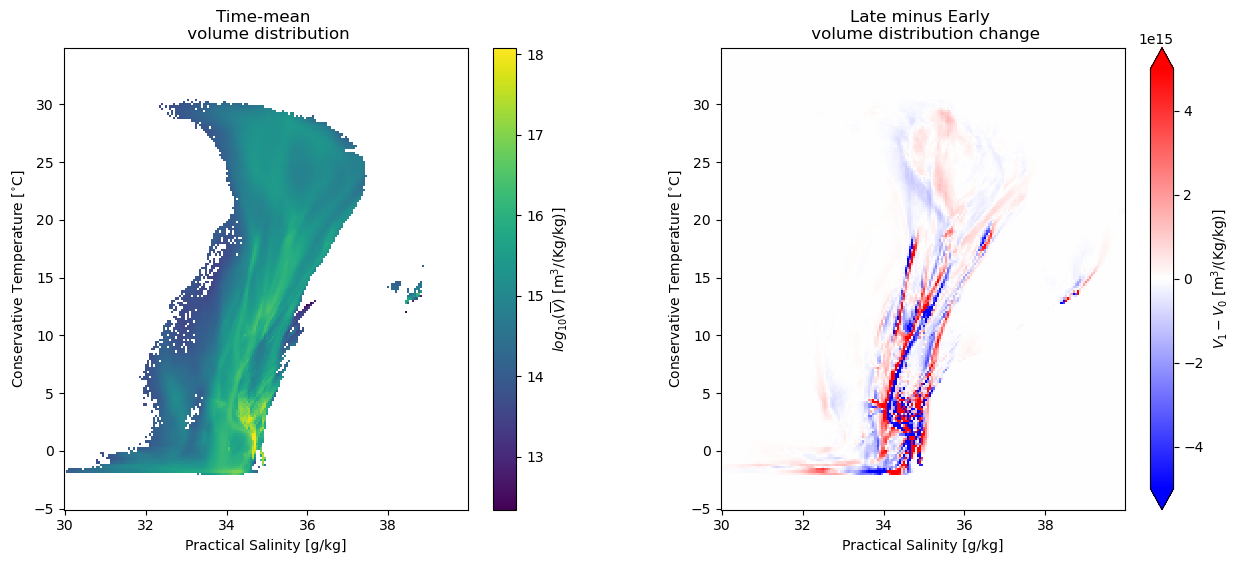

In [4]:
## Plot volumetric distribution on a regular TS grid

ECCO_TS_dist = xr.open_mfdataset('../../ECCO-Darwin/vol_TS/vol_TS_ECCO.*')

tbins = ECCO_TS_dist.T
sbins = ECCO_TS_dist.S

dtbins = np.diff(tbins)[0]
dsbins = np.diff(sbins)[0]

fig, axs = plt.subplots(1,2, figsize=(7.5*2,2.5*1.2*2), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace=0.3)
axs = axs.ravel()

(np.log10(ECCO_TS_dist.vol_TS/(dsbins*dtbins)).mean('time')).plot(ax=axs[0], cmap=plt.cm.viridis, cbar_kwargs={'label': "$log_{10}(\overline{V})$ [m$^3$/(Kg/kg)]"})
((((ECCO_TS_dist.vol_TS.isel(time=slice(Late_period[0], Late_period[1]))/(dsbins*dtbins)).mean('time')) - \
         (ECCO_TS_dist.vol_TS.isel(time=slice(Early_period[0], Early_period[1]))/(dsbins*dtbins)).mean('time'))).plot(ax=axs[1],cmap=plt.cm.bwr, cbar_kwargs={'label': "$V_1-V_0$ [m$^3$/(Kg/kg)]"}, vmin=-5e15, vmax=5e15)

for i in range(2):
    # axs[i].set_xlim(30,40)
    # axs[i].set_ylim(-3,35)
    axs[i].set_ylabel('Conservative Temperature [$^{\circ}$C]')
    axs[i].set_xlabel('Practical Salinity [g/kg]')
axs[0].set_title('Time-mean \n volume distribution')
axs[1].set_title('Late minus Early \n volume distribution change')
plt.savefig('ECCO_TS_dist.png', dpi=300, bbox_inches='tight')
plt.show()


##### Calculate the area weight scale (1/std(T)), 1/std(S))

In [5]:
T_nonan = ECCO_TS_dist.T.expand_dims(dim={"S": ECCO_TS_dist.S.size, "time":ECCO_TS_dist.time.size}).\
assign_coords({"S": ECCO_TS_dist.S, "time":ECCO_TS_dist.time})*(ECCO_TS_dist.vol_TS/ECCO_TS_dist.vol_TS)
S_nonan = ECCO_TS_dist.S.expand_dims(dim={"T": ECCO_TS_dist.T.size, "time":ECCO_TS_dist.time.size}).\
assign_coords({"T": ECCO_TS_dist.T, "time":ECCO_TS_dist.time})*(ECCO_TS_dist.vol_TS/ECCO_TS_dist.vol_TS)

#T_nonan_std = T_nonan.std(skipna=True).values
#S_nonan_std = S_nonan.std(skipna=True).values
T_nonan_std = ECCO_BSP_data.T_mean_hist.std(skipna=True).values
S_nonan_std = ECCO_BSP_data.S_mean_hist.std(skipna=True).values

T_scale = 1/T_nonan_std
S_scale = 1/S_nonan_std


# Do carbon using BSP binned data

C_nonan_std = ECCO_BSP_data.C_mean_hist.std(skipna=True).values

#C_scale = 1/C_nonan_std/10 # Fudge /10 because std of BSP data is much smaller than from regular-binned data
C_scale = 1/C_nonan_std # Fudge /10 because std of BSP data is much smaller than from regular-binned data

In [6]:
print(T_nonan_std)
print(S_nonan_std)
print(C_nonan_std)

print(T_scale)
print(S_scale)
print(C_scale)

6.213830657045328
0.5706293203753572
45.256171486595626
0.16093132484487424
1.752451134726489
0.02209643385977068


##### Calculate Early partitions for illustration

In [7]:
Part_early.load()
V_early_vals = np.log10(V_early.values)
V_early_vals[~np.isfinite(V_early_vals)] = 0

mask_regular_xr = xr.open_mfdataset('../mask_regular.nc')
mask_regular = (mask_regular_xr.mask.isel(k=0).values)
lats = mask_regular_xr.lat.values
lons = mask_regular_xr.lon.values

mask_regular[mask_regular==0] = np.nan


In [8]:
if replot_basins:
    fig, axs = plt.subplots(3,3, figsize=(7.5*1.2,7.5*1.2), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4, wspace=0.3)
    axs = axs.ravel()

    minv, maxv = 12,17

    cmap = plt.cm.viridis
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    axis_locs = [[0.1275, 0.825, 0.1, 0.05],
    [0.4075, 0.825, 0.1, 0.05],
    [0.797, 0.825, 0.1, 0.05],
    [0.1275, 0.54, 0.1, 0.05],
    [0.4075, 0.54, 0.1, 0.05],
    [0.688, 0.54, 0.1, 0.05],
    [0.1275, 0.26, 0.1, 0.05],
    [0.4075, 0.26, 0.1, 0.05],
    [0.688, 0.26, 0.1, 0.05]]

    for i in range(Basins.size):
        axins = fig.add_axes(axis_locs[i], projection = ccrs.Robinson())
        axins.pcolormesh(lons, lats, mask_regular[i,:,:], transform = ccrs.PlateCarree(), vmin=0, vmax=1, cmap=plt.cm.Reds)
        axins.add_feature(cfeature.LAND.with_scale('50m'), zorder=100, color='grey', edgecolor=None)
        axins.coastlines()
        axins.set_xticklabels([])
        axins.set_yticklabels([])
        axins.set_xticks([])
        axins.set_yticks([])
        axins.set_extent([-180,180, -83,90], crs=ccrs.PlateCarree())

    for j in range(Basins.size):
        for i in range(tree_depth):
            axs[j].add_patch(patches.Rectangle((Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,2]), \
                Part_early.isel(Basin=j)[i,1]-Part_early.isel(Basin=j)[i,0], Part_early.isel(Basin=j)[i,3]-Part_early.isel(Basin=j)[i,2], ec='black', facecolor=cmap(norm((V_early_vals[j,i]))), zorder=-1000))
        axs[j].scatter(SA_early.isel(Basin=j).values.flatten(),CT_early.isel(Basin=j).values.flatten(),20, marker='o', color='white', ec='black')
        axs[j].set_xlim(30,40)
        axs[j].set_title(Basins[j])
        axs[j].set_ylabel('Temperature [$^{\circ}$C]')
        axs[j].set_xlabel('Salinity [g/kg]')

    cax1 = fig.add_axes([0.925, 0.338, 0.02, 0.3])
    m = plt.cm.ScalarMappable(cmap=plt.cm.viridis)
    m.set_clim(minv, maxv)
    cbar1 = fig.colorbar(m, cax=cax1)
    cbar1.set_label('Volume, $log_{10}(V)$')
    plt.savefig('../Plots/BSP_binned_volumes_ECCO.png', dpi=300, bbox_inches='tight')
    plt.show()

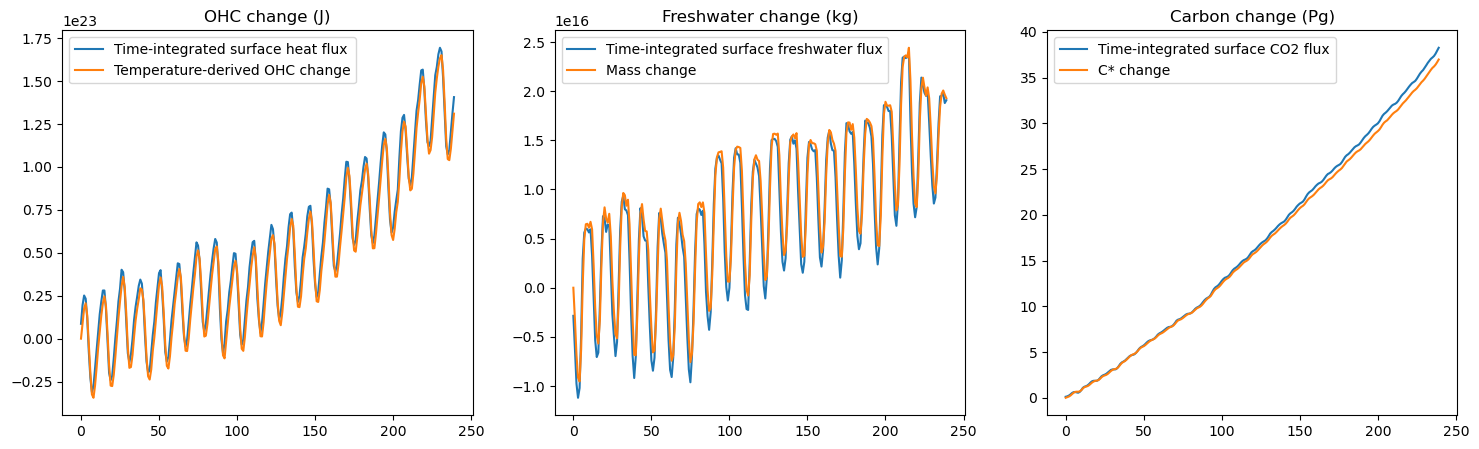

In [9]:
## Check for tracer budget closure

mmol2Pg=12*10**-18
fig, (ax0, ax1, ax2) = plt.subplots(1,3, figsize=(18,5))

## HEAT
p1=((ECCO_BSP_data.hfds_sum_hist*ECCO_dt)).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth')
p2=((rho*Cp*(ECCO_BSP_data.T_mean_hist*ECCO_BSP_data.V_sum_hist).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth'))-(rho*Cp*(ECCO_BSP_data.T_mean_hist*ECCO_BSP_data.V_sum_hist).sum('Basin').sum('Depth').isel(Time=Early_period[0])))
ax0.plot(p1,label='Time-integrated surface heat flux')
ax0.plot(p2,label='Temperature-derived OHC change')
ax0.set_title('OHC change (J)')
ax0.legend()


## SALT
#p1=((ECCO_BSP_data.sfi_sum_hist*ECCO_dt)).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth')
#p2=((rho*(ECCO_BSP_data.S_mean_hist*ECCO_BSP_data.V_sum_hist).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth'))-(rho*(ECCO_BSP_data.S_mean_hist*ECCO_BSP_data.V_sum_hist).sum('Basin').sum('Depth').isel(Time=Early_period[0])))
#ax1.plot(p1,label='Time-integrated surface salt flux')
#ax1.plot(p2,label='Salt change')
#ax1.set_title('Salt change (g)')
#ax1.legend()


## FRESHWATER
p1=((ECCO_BSP_data.wfo_sum_hist*ECCO_dt)).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth') # kg
p2=(-ECCO_BSP_data.S_mean_hist/S0*rho*ECCO_BSP_data.V_sum_hist).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth')-(-ECCO_BSP_data.S_mean_hist/S0*rho*ECCO_BSP_data.V_sum_hist).sum('Basin').sum('Depth').isel(Time=Early_period[0])
ax1.plot(p1,label='Time-integrated surface freshwater flux')
ax1.plot(p2,label='Mass change')
ax1.set_title('Freshwater change (kg)')
ax1.legend()


## CARBON
p1=((ECCO_BSP_data.Cflux_sum_hist*mmol2Pg*ECCO_dt)).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth')
#p1=((ECCO_BSP_data.Cflux_lb2_sum_hist*mmol2Pg*ECCO_dt)).isel(Time=slice(Early_period[0],Late_period[1])).cumsum('Time').sum('Basin').sum('Depth')
p2=((ECCO_BSP_data.C_mean_hist*ECCO_BSP_data.V_sum_hist*mmol2Pg).isel(Time=slice(Early_period[0],Late_period[1])).sum('Basin').sum('Depth'))-((ECCO_BSP_data.C_mean_hist*ECCO_BSP_data.V_sum_hist*mmol2Pg).sum('Basin').sum('Depth').isel(Time=Early_period[0]))
ax2.plot(p1,label='Time-integrated surface CO2 flux')
ax2.plot(p2,label='C* change')
ax2.set_title('Carbon change (Pg)')
ax2.legend()


In [10]:
## Load SF data here, if provided

if SF:
    ## Calculate the cumulative time integrated surface fluxes 

    HFDS_cumsum = ((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
        -((ECCO_BSP_data.hfds_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: J
    SFI_cumsum = ((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
         -((ECCO_BSP_data.sfi_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: g
    WFO_cumsum = ((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
         -((ECCO_BSP_data.wfo_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0]))# units: kg
    Cflux_cumsum = ((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                    -((ECCO_BSP_data.Cflux_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
    if fluxerr:
        Cflux_ub_cumsum = ((ECCO_BSP_data.Cflux_ub_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_ub_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        Cflux_lb_cumsum = ((ECCO_BSP_data.Cflux_lb_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_lb_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        Cflux_ub2_cumsum = ((ECCO_BSP_data.Cflux_ub2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_ub2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        Cflux_lb2_cumsum = ((ECCO_BSP_data.Cflux_lb2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_lb2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        Cflux_err_cumsum = ((ECCO_BSP_data.Cflux_mod_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_mod_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        Cflux_err2_cumsum = ((ECCO_BSP_data.Cflux_mod2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Late_period[-1]))\
                        -((ECCO_BSP_data.Cflux_mod2_sum_hist*ECCO_dt).cumsum('Time').isel(Time=Early_period[0])) # units: mmol-C
        
    if noprior:
        
        Cflux_cumsum = np.zeros_like(Cflux_cumsum)
        

    
    dt_cumsum = ECCO_dt[0,Early_period[0]:Late_period[-1],0].sum() # units: seconds
    
    
    ## The final dflux value is then scaled by the time between the middle of t1 and the middle of t2
    dhfds = HFDS_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dsfi = SFI_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    dwfo = WFO_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    
    dCflux = Cflux_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_ub_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_lb_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_ub2_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_lb2_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_err_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    #dCflux = Cflux_err2_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))
    
    dt = dt_cumsum*((np.mean(Late_period)-np.mean(Early_period))/(Late_period[-1]-Early_period[0]))

    ## Convert dflux to equivalent T or S change

    dT_hfds = dhfds/(Cp*rho*V_early) # units: C
    dS_sfi = dsfi/(rho*V_early) # units: g/kg
    dS_wfo = -dwfo*S0/(rho*V_early) # units: g/kg
    dC_Cflux = dCflux/V_early # units: mmol-C/m^3
#    dT_hfds = 2*dhfds/(Cp*rho*(V_early+V_late)) # units: C
#    dS_sfi = 2*dsfi/(rho*(V_early+V_late)) # units: g/kg
#    dS_wfo = -2*dwfo*S0/(rho*(V_early+V_late)) # units: g/kg
#    dC_Cflux = 2*dCflux/(V_early+V_late) # units: mmol-C/m^3

# Load the result of a previous run

if prior_opt:
    
    Opt_result = xr.open_mfdataset('../Outputs/testing_transports.nc')
   
    dC_Cflux = (Opt_result.dC_Cflux.values*V_early.values.flatten() + Opt_result.dC_adjustment.values*V_late.values.flatten()).reshape(Basins.size,tree_depth)/V_early
    Opt_result.close()

In [11]:
# Flatten the early and late variables to a 1D array
Vol_1 = V_early.values.flatten()
Vol_2 = V_late.values.flatten()
S_1 = SA_early.values.flatten()-S0 # Remove reference salinity S0
S_2 = SA_late.values.flatten()-S0 # Remove reference salinity S0
T_1 = CT_early.values.flatten()
T_2 = CT_late.values.flatten()
C_1 = C_early.values.flatten()
C_2 = C_late.values.flatten()
A_1 = A_early.values.flatten()
A_2 = A_late.values.flatten()


# Do the same for basin index
Basin_1 = np.zeros_like(V_early)
Basin_2 = np.zeros_like(V_early)
Basin_names = []
for i in range(np.array(Basins).size):
    Basin_1[i,:] = i
    Basin_2[i,:] = i
    for j in range(V_early.shape[-1]):
        #... and for basin name
        Basin_names.append(Basins[i])



Basin_1_inds = Basin_1.flatten()
Basin_2_inds = Basin_2.flatten()

#... and for the edges of the BSP bins
## Here we calculate the mean TS edges averaged over both early and late times
S_start = (0.5*(Part_early.values[:,:,0]+Part_late.values[:,:,0])).flatten()-S0 # Remove reference salinity S0
S_end = (0.5*(Part_early.values[:,:,1]+Part_late.values[:,:,1])).flatten()-S0 # Remove reference salinity S0
T_start = (0.5*(Part_early.values[:,:,2]+Part_late.values[:,:,2])).flatten()
T_end = (0.5*(Part_early.values[:,:,3]+Part_late.values[:,:,3])).flatten()

# Any NaNs are zeroed out
S_1[np.isnan(S_1)] = 0
S_2[np.isnan(S_2)] = 0
T_1[np.isnan(T_1)] = 0
T_2[np.isnan(T_2)] = 0
C_1[np.isnan(C_1)] = 0
C_2[np.isnan(C_2)] = 0

In [12]:
## IF SURFACE FLUXES ARE PROVIDED -- add here ##
if SF:
    S_pre = SA_early.values.flatten()-S0
    S_1 = SA_early.values.flatten()-S0+dS_wfo.values.flatten()
    T_pre = CT_early.values.flatten()
    T_1 = CT_early.values.flatten()+dT_hfds.values.flatten()

    S_1[np.isnan(S_1)] = 0
    T_1[np.isnan(T_1)] = 0
    S_1[~np.isfinite(S_1)] = 0
    T_1[~np.isfinite(T_1)] = 0
    
    C_pre = C_early.values.flatten()         
    C_1 = C_early.values.flatten() + dC_Cflux.values.flatten()
    C_1[np.isnan(C_1)] = 0
    C_1[~np.isfinite(C_1)] = 0


In [13]:
## Here, we create the tracers and volumes matrices, which will be fed into the MTM function

volumes = np.stack((Vol_1, Vol_2), axis=0)/volnorming # Shape: [2 x N]

salinities = np.stack((S_1, S_2), axis=0)
temps = np.stack((T_1, T_2), axis=0)
carbon = np.stack((C_1, C_2), axis=0)


tracers = np.stack((salinities, temps, carbon),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers
#tracers = np.stack((salinities, temps),axis=1) # Shape: [2 x M x N], where M = 2 for just T and S, and M>2 for T,S+other tracers

In [14]:
print('Total number of bins =', int(Vol_1.shape[0]))
N = int(Vol_1.shape[0])

Total number of bins = 576


#### Plot time-mean volume

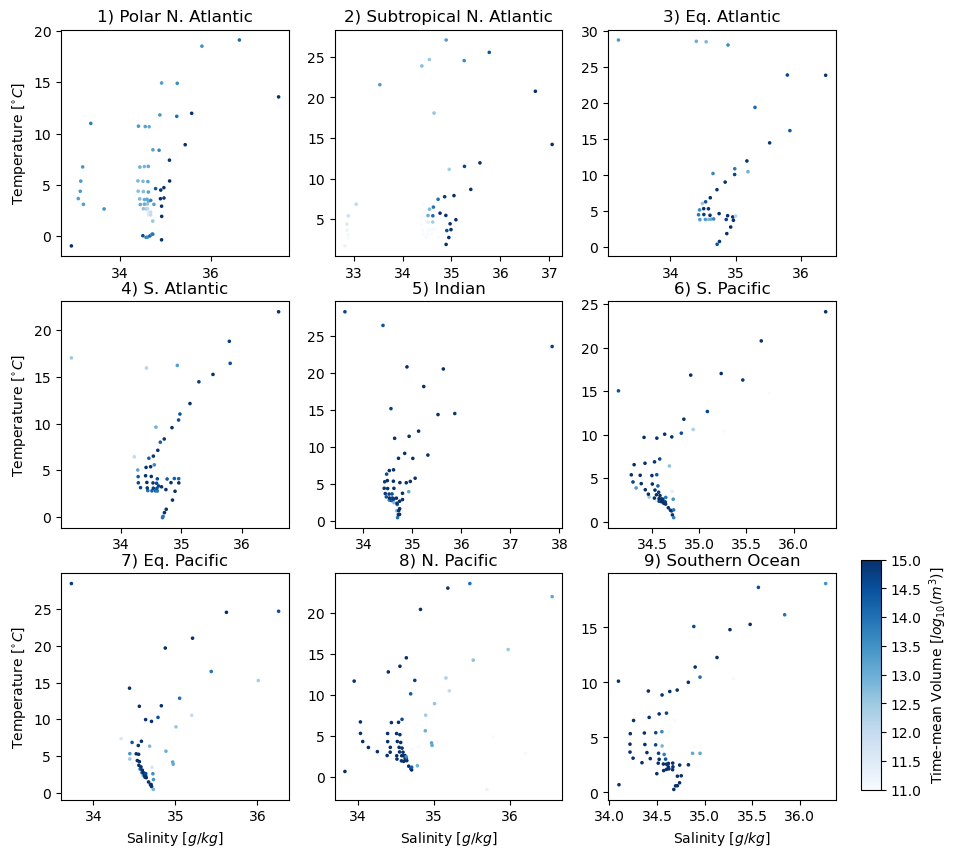

In [15]:
#fig, axs = plt.subplots(3,5, figsize=(16,10), facecolor='w', edgecolor='k')
fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel()
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = 11,15
cmap = 'Blues'

for bx in range(Basins.size):
    axs[bx].scatter(SA_early[bx,:],CT_early[bx,:], 10, np.log10(V_early[bx,:]),cmap=cmap, vmin=minv, vmax=maxv, marker = '.')
    #axs[bx].set_xlim(32,39)
    #axs[bx].set_ylim(-3,32)
    label=str(bx+1)+') '+str(Basins[bx])
    axs[bx].set_title(label)
#    if bx==0 or bx==5 or bx==9:
#        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
#    if bx==8 or bx==9 or bx==10 or bx==11 or bx==12:
#        axs[bx].set_xlabel('Salinity [$g/kg$]')

    if bx==0 or bx==3 or bx==6:
        axs[bx].set_ylabel('Temperature [$^{\circ}C$]')
    if bx==6 or bx==7 or bx==8:
        axs[bx].set_xlabel('Salinity [$g/kg$]')
        
m = plt.cm.ScalarMappable(cmap=cmap)
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('Time-mean Volume [$log_{10}(m^3)$]')
if saveplots:
    plt.savefig('BSP_volumes.png', bbox_inches='tight', dpi=300)
plt.show()

### Define constraints

We must define whether a BSP bin is allowed to transport volume to another BSP bin. In the simplest case, all bins are allowed to transport to one another - but this yields nonphysical transport across vast distances and TS bounds.
To improve on this, two connectivity constraints are used: 
1) Are the basins adjacent? This is defined via the connectivity array, below
2) If YES, do the BSP bins have overlapping (or the same) TS boundaries?\
If yes, the bins are connected. If no, they are not.

In [16]:
# Array defining the connection between the 9 basins;
# 1 = connected, 0 = disconnected
# connectivity_array = np.ones((Basins.size,Basins.size))

connectivity_array = np.zeros((Basins.size,Basins.size))

#connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 0, 0]
connectivity_array[0,:] = [1, 1, 0, 0, 0, 0, 0, 1, 0] # Open Bering Strait
connectivity_array[1,:] = [1, 1, 1, 0, 0, 0, 0, 0, 0]
connectivity_array[2,:] = [0, 1, 1, 1, 0, 0, 0, 0, 0]
connectivity_array[3,:] = [0, 0, 1, 1, 0, 0, 0, 0, 1]
connectivity_array[4,:] = [0, 0, 0, 0, 1, 0, 1, 0, 1]
connectivity_array[5,:] = [0, 0, 0, 0, 0, 1, 1, 0, 1]
connectivity_array[6,:] = [0, 0, 0, 0, 1, 1, 1, 1, 0]
#connectivity_array[7,:] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
connectivity_array[7,:] = [1, 0, 0, 0, 0, 0, 1, 1, 0] # Open Bering Strait
connectivity_array[8,:] = [0, 0, 0, 1, 1, 1, 0, 0, 1]

d = {Basins[0]: connectivity_array.T[0,:],\
    Basins[1]: connectivity_array.T[1,:],\
    Basins[2]: connectivity_array.T[2,:],\
    Basins[3]: connectivity_array.T[3,:],\
    Basins[4]: connectivity_array.T[4,:],\
    Basins[5]: connectivity_array.T[5,:],\
    Basins[6]: connectivity_array.T[6,:],\
    Basins[7]: connectivity_array.T[7,:],\
    Basins[8]: connectivity_array.T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table


,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Subtropical N. Atlantic,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
Indian,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
Eq. Pacific,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
N. Pacific,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
Southern Ocean,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0


In [17]:
# Array defining the transport between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint

ncons=2
transport_array = np.zeros((Basins.size,Basins.size,ncons))

# Constrain ITF
#transport_array[4,:,0] = [0, 0, 0, 0, 0, 0, 1, 0, 0]
#transport_array[6,:,0] = [0, 0, 0, 0, -1, 0, 0, 0, 0]

# Constrain 40N
#transport_array[1,:,1] = [1, 0, 0, 0, 0, 0, 0, 0, 0]
#transport_array[0,:,2] = [0, -1, 0, 0, 0, 0, 0, 0, 0]

# Constrain 10N
#transport_array[2,:,2] = [0, 1, 0, 0, 0, 0, 0, 0, 0]

# Constrain 10S

#transport_array[3,:,3] = [0, 0, 1, 0, 0, 0, 0, 0, 0]

# Constrain 35S

#transport_array[8,:,4] = [0, 0, 0, 1, 0, 0, 0, 0, 0]

# Constrain Bering Strait
transport_array[0,:,0] = [0, 0, 0, 0, 0, 0, 0, -1, 0]
transport_array[7,:,1] = [1, 0, 0, 0, 0, 0, 0, 0, 0]

tablecons=1

d = {Basins[0]: transport_array[:,:,tablecons].T[0,:],\
    Basins[1]: transport_array[:,:,tablecons].T[1,:],\
    Basins[2]: transport_array[:,:,tablecons].T[2,:],\
    Basins[3]: transport_array[:,:,tablecons].T[3,:],\
    Basins[4]: transport_array[:,:,tablecons].T[4,:],\
    Basins[5]: transport_array[:,:,tablecons].T[5,:],\
    Basins[6]: transport_array[:,:,tablecons].T[6,:],\
    Basins[7]: transport_array[:,:,tablecons].T[7,:],\
    Basins[8]: transport_array[:,:,tablecons].T[8,:]}
    
table = pd.DataFrame(data=d, index=Basins)
table

,Polar N. Atlantic,Subtropical N. Atlantic,Eq. Atlantic,S. Atlantic,Indian,S. Pacific,Eq. Pacific,N. Pacific,Southern Ocean
Polar N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Subtropical N. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Atlantic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Indian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
S. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eq. Pacific,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
N. Pacific,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Southern Ocean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
# Array defining maximum northward transports between the 9 basins;
# +/-1 = connected (North = +, East = +), 0 = no constraint

#transmax_array = np.zeros((Basins.size,Basins.size,10))

#transmax_array[1,:,0] = [1, 0, 0, 0, 0, 0, 0, 0, 0] # STNA to PNA
#transmax_array[2,:,1] = [0, 1, 0, 0, 0, 0, 0, 0, 0] # EA to STNA
#transmax_array[3,:,2] = [0, 0, 1, 0, 0, 0, 0, 0, 0] # SA to EA
#transmax_array[8,:,3] = [0, 0, 0, 1, 0, 0, 0, 0, 0] # SO to SA
#transmax_array[8,:,4] = [0, 0, 0, 0, 0, 1, 0, 0, 0] # SO to SP
#transmax_array[5,:,5] = [0, 0, 0, 0, 0, 0, 1, 0, 0] # SP to EP
#transmax_array[6,:,6] = [0, 0, 0, 0, 0, 0, 0, 1, 0] # EP to NP
#transmax_array[4,:,7] = [0, 0, 0, 0, 0, 0, 1, 0, 0] # ITF
#transmax_array[8,:,8] = [0, 0, 0, 0, 1, 0, 0, 0, 0] # SO to IO
#transmax_array[7,:,9] = [1, 0, 0, 0, 0, 0, 0, 0, 0] # NP to PNA

#tablecons=9

#d = {Basins[0]: transmax_array[:,:,tablecons].T[0,:],\
#    Basins[1]: transmax_array[:,:,tablecons].T[1,:],\
#    Basins[2]: transmax_array[:,:,tablecons].T[2,:],\
#    Basins[3]: transmax_array[:,:,tablecons].T[3,:],\
#    Basins[4]: transmax_array[:,:,tablecons].T[4,:],\
#    Basins[5]: transmax_array[:,:,tablecons].T[5,:],\
#    Basins[6]: transmax_array[:,:,tablecons].T[6,:],\
#    Basins[7]: transmax_array[:,:,tablecons].T[7,:],\
#    Basins[8]: transmax_array[:,:,tablecons].T[8,:]}
    
#table = pd.DataFrame(data=d, index=Basins)
#table

In [19]:
# Define whether a bin is connected to every other bin
# The two constraints used are: are the basins adjacent? 
# If yes, are the bin indices the same? 
# If yes, the bins are connected; if no, they are not connected. 

# connected = np.ones((Vol_1.size, Vol_1.size)) ## For all connections case

trans_big = np.zeros((Vol_1.size, Vol_1.size, ncons))
#transmax_big = np.zeros((Vol_1.size, Vol_1.size, transmax_array.shape[2]))
connected = np.zeros((Vol_1.size, Vol_1.size))

for i in tqdm(range(Vol_1.size)):
    for j in range(Vol_2.size):
        for k in range(ncons):
            trans_big[i,j,k] = transport_array[int(Basin_1_inds[i]), int(Basin_2_inds[j]),k]
#        for k in range(transmax_array.shape[2]):
#            transmax_big[i,j,k] = transmax_array[int(Basin_1_inds[i]), int(Basin_2_inds[j]),k]
        if connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]>0:
            connected[i,j] = 1 ## For NO DOCKING case
            ## UNCOMMENT BELOW IF YOU WANT DOCKING AGAIN
            #if Basin_names[i] == Basin_names[j]:
            #    connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]
            #elif S_start[i]==S_start[j] and T_start[i]==T_start[j]:
            #    connected[i,j] = connectivity_array[int(Basin_1_inds[i]), int(Basin_2_inds[j])]

constraints = connected # Shape: An [N x N] matrix

transport = trans_big  # Shape: An [N x N] matrix
#transport_max = transmax_big

#plt.pcolormesh(connected)

  0%|          | 0/576 [00:00<?, ?it/s]

### Defining weights

In [20]:
## We create a weight matrix
# For sqrt(1/Area)
A_2_modified = A_2.copy()
#A_2_modified[A_2_modified==0] = 10**-15 # 10**-15 is the lowest I can make it for tree_depth=5 without it breaking
#A_2_modified[A_2_modified==0] = 10**5 # 10**5 lowest value for 3 tracer opt without it breaking
A_2_modified[A_2_modified==0] = np.nanmin(A_2[A_2>0])

print(np.nanmin(A_2[A_2>0]))

area_weight = np.sqrt(areanorming/A_2_modified)

area_cons = A_2/A_2-1
area_cons[np.isnan(area_cons)] = 1

## For log(Area)
#area_weight = np.log10(areanorming)/(np.log10(A_2))
#area_weight[area_weight==0] = 100

#weights = np.stack((ST_scale*area_weight,area_weight,np.ones((C_1.size))), axis=0) # Shape: An [M x N] matrix
#weights = np.stack((S_scale*area_weight,T_scale*area_weight,np.ones((C_1.size))), axis=0) # Shape: An [M x N] matrix
#hard_area = np.stack((area_cons,area_cons), axis=0)

weights = np.stack((S_scale*area_weight,T_scale*area_weight,C_scale*area_weight), axis=0) # Shape: An [M x N] matrix
hard_area = np.stack((area_cons,area_cons,area_cons), axis=0)


716380.1333333333


### Run optimisation

In [21]:
## We run the optimiser to get the transports between water masses and the T,S mixed and T,S adjustment
# threshold = 1*(range_yrs*yr2sec/volnorming) #xxx m/s

yr2sec=3600*24*365.25

# if SF:
#     trans_val = -15*(10**6*(range_yrs*yr2sec/volnorming)) # xxx Sv
# else:
#     trans_val = 0


trans_val1 = -15*(10**6*(dt/volnorming)) # ITF net transport

trans_val3 = 18*(10**6*(dt/volnorming)) # Atlantic northward transport
#trans_val3 = -29.2*(10**6*(dt/volnorming)) # Atlantic southward transport

trans_val4 = 0*(10**6*(dt/volnorming)) # Bering Straight southward
trans_val5 = 1.1*(10**6*(dt/volnorming)) # Bering Straight northward

trans_val=np.hstack((trans_val4, trans_val5))
#trans_val=trans_val1

## Function has form MTM.optimise(tracers=tracers, volumes=volumes, cons_matrix = constraints, 
#                                 trans = [transport,trans_val], Asection = [connected_Asection,threshold], weights=weights, hard_area = hard_area, transmax = [transport_max,transmax_val])
#     '''constraint = [G @ Q = V2 * C2 - G @ C1]
#         cost = cp.sum_squares(Q*V1/A1)

#         where C1 is the initial and C2 is the final tracer concentrations.'''

#result = MTM_3.optimise(tracers=tracers, volumes=volumes, cons_matrix=constraints, weights=weights, hard_area = hard_area, trans = [transport,trans_val])
result = MTM_3.optimise(tracers=tracers, volumes=volumes, cons_matrix=constraints, weights=weights, trans = [transport,trans_val])

#result = MTM_3.optimise(tracers=tracers, volumes=volumes, cons_matrix=constraints, weights=weights)


g_ij = result['g_ij'] ## An [N x N] matrix of transports between WMs
Mixing = result['Mixing'] ## An [M x N] matrix of dtracer mixing for each WM
Adjustment = result['Adjustment'] ## An [M x N] matrix of dtracer adjustment for each WM
G = result['G']

Using 2 transport constraints
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Oct 16 10:49:47 PM: Your problem has 118784 variables, 4 constraints, and 0 parameters.
(CVXPY) Oct 16 10:49:47 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 16 10:49:47 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 16 10:49:47 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 16 10:49:47 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 16 10:49:47 PM: Reduction chain: Dcp2Cone -> CvxA

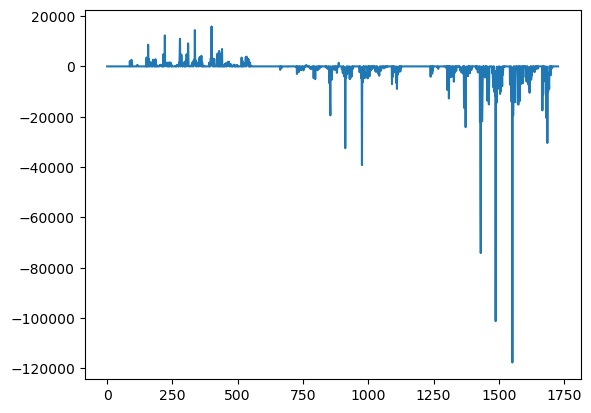

In [22]:
b = np.concatenate((volumes[1,:]*tracers[1,1,:]*weights[1,:],\
                volumes[1,:]*tracers[1,0,:]*weights[0,:],\
                   volumes[1,:]*tracers[1,2,:]*weights[2,:]), axis=0)

plt.plot(b)

In [23]:
## Plot the transport g_ij from WM initial to WM final

#plt.rcParams["figure.figsize"] = (15,15)
#plt.pcolormesh(g_ij,vmin=0,vmax=0.005)
#cbar = plt.colorbar()
#cbar.set_label('Transport between WMs')
#plt.xlabel('Final WM')
#plt.ylabel('Initial WM')
#plt.show()
#if saveplots:
#    plt.savefig('g_ij.png', bbox_inches='tight', dpi=300)

In [24]:
## Break down the Mixing and Adjustment matrices into their constituent tracers
dT_mixing = Mixing[1,:]
dS_mixing = Mixing[0,:]

dT_adj = Adjustment[1,:]
dS_adj = Adjustment[0,:]

## Uncomment if M>2
dC_mixing = Mixing[2,:]
dC_adj = Adjustment[2,:]



In [25]:
## Validation check of total carbon adjustment

#display(np.nansum(dC_Cflux*np.isfinite(dC_Cflux)*A_late))
#display(np.nansum(dC_adj*A_2))

display(np.nansum(dC_Cflux*(V_early)))
display(np.nansum(dC_adj*(Vol_2)))
display(np.nansum(dC_adj*Vol_2)/np.nansum(dC_Cflux*V_early))
display(max(dC_adj*Vol_2/volnorming))
print(np.nanmean(abs(dC_adj*Vol_2/volnorming)))

0.0

1.5642887033201444e+18

inf

147.10256050952768

3.1943551339093728


In [26]:
## Size check of total T adjustment

#display(np.nansum(dT_hfds*(V_early)))
#display(np.nansum(dT_adj*(Vol_2)))
#display(np.nansum(dT_adj*(Vol_2))/np.nansum((T_2-T_1)*(Vol_2)))
#display(np.nansum(dT_adj*Vol_2)/np.nansum(dT_hfds*V_early))
display(max(dT_adj*Vol_2/volnorming))
print(np.nanmean(abs(dT_adj*Vol_2/volnorming)))


10.321383004061484

0.3297213061683566


In [27]:
## Size check of total S adjustment

#display(np.nansum(dS_wfo*(V_early)))
#display(np.nansum(dS_adj*(Vol_2)))
#display(np.nansum(dS_adj*(Vol_2))/np.nansum((S_2-S_1)*(Vol_2)))
#display(np.nansum(dS_adj*Vol_2)/np.nansum(dS_wfo*V_early))
display(max(dS_adj*Vol_2/volnorming))
print(np.nanmean(abs(dS_adj*Vol_2/volnorming)))

0.7670936832703427

0.016723307284064966


### Save outputs

In [28]:
## Set run ID

print('Please type in your Experiment ID')
expt_ID = input()
print('Your Experiment ID is '+expt_ID)
file_path = '../Outputs/'+expt_ID+'_transports.nc'


Please type in your Experiment ID


 zeroprior


Your Experiment ID is zeroprior


In [29]:
## Save MTM outputs to netcdf

import os
if os.path.exists(file_path):
   os.remove(file_path)
   print('File deleted')

da_dT_mixing = xr.DataArray(data = dT_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Mixing", units="\Delta K", variable_id="ECCO Tmix"))
da_dS_mixing = xr.DataArray(data = dS_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Mixing", units="\Delta g/kg", variable_id="ECCO Smix"))
da_dC_mixing = xr.DataArray(data = dC_mixing, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Carbon Mixing", units="\Delta mmol/m^3", variable_id="ECCO Cmix"))
da_dT_adjustment = xr.DataArray(data = dT_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Temperature Adjustment", units="\Delta K", variable_id="ECCO Tadj"))
da_dS_adjustment = xr.DataArray(data = dS_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Salinity Adjustment", units="\Delta g/kg", variable_id="ECCO Sadj"))
da_dC_adjustment = xr.DataArray(data = dC_adj, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Carbon Adjustment", units="\Delta mmol/m^3", variable_id="ECCO Cadj"))
da_dC_Cflux = xr.DataArray(data = dC_Cflux.values.flatten(), dims = ["WM_number"],
                       coords=dict(WM_number = np.arange(0,N)),
                    attrs=dict(description="Carbon flux", units="\Delta mmol/m^3", variable_id="ECCO Cflux"))
da_gij = xr.DataArray(data = g_ij*volnorming, dims = ["WM_initial", "WM_final"],
                           coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                        attrs=dict(description="Volume transport", units="m^3", variable_id="ECCO Gij"))
da_Vol_early = xr.DataArray(data = Vol_1, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Early period volume", units="m^3", variable_id="Vol init"))
da_Vol_late = xr.DataArray(data = Vol_2, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Late period volume", units="m^3", variable_id="Vol final"))
da_A_early = xr.DataArray(data = A_1, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Early period area", units="m^2", variable_id="Area init"))
da_A_late = xr.DataArray(data = A_2, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Late period area", units="m^2", variable_id="Area final"))
da_C_early = xr.DataArray(data = C_1, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Early period carbon", units="mmol-C/m^3", variable_id="C early"))
da_C_late = xr.DataArray(data = C_2, dims = ["WM_number"],
                           coords=dict(WM_number = np.arange(0,N)),
                        attrs=dict(description="Late period carbon", units="mmol-C/m^3", variable_id="C late"))
da_connected = xr.DataArray(data = connected, dims = ["WM_initial", "WM_final"],
                            coords=dict(WM_initial = np.arange(0,N), WM_final = np.arange(0,N)),
                            attrs=dict(description="Connectivity matrix", units="None", variable_id="connectivity"))

## Create xarray DataSet that will hold all these DataArrays
ds_BSP = xr.Dataset()
ds_BSP['dT_mixing'] = da_dT_mixing
ds_BSP['dS_mixing'] = da_dS_mixing
ds_BSP['dC_mixing'] = da_dC_mixing
ds_BSP['dT_adjustment'] = da_dT_adjustment
ds_BSP['dS_adjustment'] = da_dS_adjustment
ds_BSP['dC_adjustment'] = da_dC_adjustment
ds_BSP['dC_Cflux'] = da_dC_Cflux
ds_BSP['C_early'] = da_C_early
ds_BSP['C_late'] = da_C_late
ds_BSP['gij'] = da_gij
ds_BSP['Vol_early'] = da_Vol_early
ds_BSP['Vol_late'] = da_Vol_late
ds_BSP['A_early'] = da_A_early
ds_BSP['A_late'] = da_A_late
ds_BSP['init_early'] = init_early
ds_BSP['init_late'] = init_late
ds_BSP['dyrs'] = dyrs
ds_BSP['Basins'] = Basins
ds_BSP['tree_depth'] = tree_depth
ds_BSP['dt'] = dt
ds_BSP['connectivity'] = da_connected

ds_BSP.to_netcdf(file_path, mode='w')
print('File saved')


File saved


## Plotting results in TS coordinates

#### Vector plot of mixing and adjustment

In [ ]:
## Vector Plot
# Here, we plot the vectors of mixing and adjustment per year from the initial watermass outwards

fig, axs = plt.subplots(3,3, figsize=(15,15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
    
k=0
for i in range(np.array(Basins).size):
    for j in range(Part_early.shape[1]):
        axs[i].scatter(S_1[k]+S0,T_1[k]+T0,\
               s=10,\
              marker = 'o', facecolor='none', edgecolor='grey', label = 't2', zorder=100)
        axs[i].scatter(S_2[k]+S0,T_2[k],
               s=10,\
              marker = 'v', facecolor='none', edgecolor='grey', label = 't1', zorder=100)
        if ~np.isnan(dT_mixing[k]) | ~np.isnan(dS_mixing[k]):
            axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]+T0), xytext=((S_1[k]+dS_mixing[k])+S0, (T_1[k]+T0+dT_mixing[k])),
  arrowprops=dict(arrowstyle="<-", color='blue'))
            axs[i].annotate('', xy=(S_1[k]+dS_mixing[k]+S0, T_1[k]+T0+dT_mixing[k]), xytext=((S_1[k]+dS_mixing[k]+dS_adj[k])+S0, (T_1[k]+T0+dT_mixing[k]+dT_adj[k])),
  arrowprops=dict(arrowstyle="<-", color='red'))
        else:
            axs[i].annotate('', xy=(S_1[k]+S0, T_1[k]+T0), xytext=((S_1[k]+dS_adj[k])+S0, (T_1[k]+T0+dT_adj[k])),
  arrowprops=dict(arrowstyle="<-", color='red'))
        # axs[i].set_xlim(30,40)
        # axs[i].set_ylim(-4,32)
        label=str(i+1)+') '+Basins[i]
        axs[i].set_title(label)
        k=k+1

if saveplots:        
    plt.savefig('Minimisation_vectors.png', dpi=300, bbox_inches='tight')

plt.show()


#### Temperature

In [ ]:
## Volume weighting for each water mass to be plotted
Vol_weight=(Vol_1+Vol_2)/2

In [ ]:
## Visualise T mixing as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        #axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dT_mixing[k])), zorder=100)
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dT_mixing[k]*Vol_weight[k]/volnorming)), zorder=100)
        # axs[i].add_patch(patches.Rectangle((x0[j], y0[j]), w[j], h[j], ec=None, color=cmap(norm(10*S_Av_adj[k]/dyrs))))
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$')
if saveplots:
    plt.savefig('dT_mix.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
if SF:

## Visualise T surface flux as a colourmap on the time-mean watermass locations

    fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 
    cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

    minv, maxv = -1,1
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    k=0
    for i in range(np.array(Basins).size):
        for j in range(ECCO_BSP_data.Depth.size):
            #axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dT_hfds.values.flatten()[k])), zorder=100)
            axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dT_hfds.values.flatten()[k]*Vol_weight[k]/volnorming)), zorder=100)
            axs[i].set_xlim(32,39)
            axs[i].set_ylim(-3,32)
            axs[i].set_title(Basins[i])
            axs[i].grid(True)
            k=k+1
        if i==0 or i==3 or i==6:
            axs[i].set_ylabel('Temperature [$^{\circ}C$]')
        if i==6 or i==7 or i==8:
            axs[i].set_xlabel('Salinity [$g/kg$]')
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('$^{\circ}C$')
    if saveplots:
        plt.savefig('dT_surf.png', dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
## Visualise T adjustment as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dT_adj[k]*Vol_weight[k]/volnorming)), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$^{\circ}C$') 
if saveplots:
    plt.savefig('dT_adj', dpi=300, bbox_inches='tight')

plt.show()


#### Salinity

In [ ]:
## Visualise S mixing as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -0.1,0.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dS_mixing[k]*Vol_weight[k]/volnorming)), zorder=100)
        # axs[i].add_patch(patches.Rectangle((x0[j], y0[j]), w[j], h[j], ec=None, color=cmap(norm(10*S_Av_adj[k]/dyrs))))
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$')
if saveplots:
    plt.savefig('dS_mix.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
if SF:
## Visualise S surface flux as a colourmap on the time-mean watermass locations

    fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .2, wspace=0.2)
    axs = axs.ravel() 
    cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

    minv, maxv = -0.1,0.1
    cmap = plt.cm.bwr
    norm = plt.Normalize(minv, maxv)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    k=0
    for i in range(np.array(Basins).size):
        for j in range(ECCO_BSP_data.Depth.size):
            axs[i].scatter(0.5*(S_1[k]+S_2[k]+70), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dS_wfo.values.flatten()[k]*Vol_weight[k]/volnorming)), zorder=100)
            axs[i].set_xlim(32,39)
            axs[i].set_ylim(-3,32)
            axs[i].set_title(Basins[i])
            axs[i].grid(True)
            k=k+1
        if i==0 or i==3 or i==6:
            axs[i].set_ylabel('Temperature [$^{\circ}C$]')
        if i==6 or i==7 or i==8:
            axs[i].set_xlabel('Salinity [$g/kg$]')
    m = plt.cm.ScalarMappable(cmap='bwr')
    m.set_clim(minv, maxv)
    cbar = fig.colorbar(m, cax=cax, orientation='vertical')
    cbar.set_label('$g/kg$')
    if saveplots:
        plt.savefig('dS_surf.png', dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
## Visualise S adjustment as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -0.1,0.1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dS_adj[k]*Vol_weight[k]/volnorming)), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('$g/kg$') 
if saveplots:
    plt.savefig('dS_adj.png', dpi=300, bbox_inches='tight')

plt.show()


#### Carbon

In [ ]:
## Visualise C mixing as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -5,5
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dC_mixing[k]*Vol_weight[k]/volnorming)), zorder=100)
        #axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dC_mixing[k])), zorder=100)
        # axs[i].add_patch(patches.Rectangle((x0[j], y0[j]), w[j], h[j], ec=None, color=cmap(norm(10*S_Av_adj[k]/dyrs))))
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('mmol-C/m$^3$')
if saveplots:
    plt.savefig('dC_mix.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
## Visualise C surface flux as a colourmap on the time-mean watermass locations

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -5,5
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+70), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dC_Cflux.values.flatten()[k]*Vol_weight[k]/volnorming)), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('mmol-C/m$^3$')
if saveplots:
    plt.savefig('dC_surf.png', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
## Visualise C adjustment as a colourmap on the time-mean watermass locations (should be equivalent to model truth above)

saveplots = True

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -5,5
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(dC_adj[k]*Vol_weight[k]/volnorming)), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('mmol-C/m$^3$')
if saveplots:
    plt.savefig('dC_adj.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
## Check change in C is consistent with the combination of mixing and adjustment

Cmixed=np.matmul(carbon[0,:],g_ij)/volumes[1,:]

fig, axs = plt.subplots(3,3, figsize=(10,10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=0.2)
axs = axs.ravel() 
cax = fig.add_axes([0.925, 0.12, 0.02, 0.23])

minv, maxv = -1,1
cmap = plt.cm.bwr
norm = plt.Normalize(minv, maxv)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

k=0
for i in range(np.array(Basins).size):
    for j in range(ECCO_BSP_data.Depth.size):
        axs[i].scatter(0.5*(S_1[k]+S_2[k]+S0*2), 0.5*(T_1[k]+T_2[k]+T0*2), 10, color=cmap(norm(C_2[k]-dC_adj[k]-Cmixed.flatten()[k])), zorder=100)
        axs[i].set_xlim(32,39)
        axs[i].set_ylim(-3,32)
        axs[i].set_title(Basins[i])
        axs[i].grid(True)
        k=k+1
    if i==0 or i==3 or i==6:
        axs[i].set_ylabel('Temperature [$^{\circ}C$]')
    if i==6 or i==7 or i==8:
        axs[i].set_xlabel('Salinity [$g/kg$]')
m = plt.cm.ScalarMappable(cmap='bwr')
m.set_clim(minv, maxv)
cbar = fig.colorbar(m, cax=cax, orientation='vertical')
cbar.set_label('mmol-C/m$^3$') 
if saveplots:
    plt.savefig('Minimisation_9basins_C_star_res.png', dpi=300, bbox_inches='tight')

plt.show()
